# Contents
- [Purpose](#Purpose)
- [Library import](#Library-import)
- [Input params](#Input-params)
- [Function definitions](#Function-definitions)
- [Radius of influence](#Radius-of-influence)
- [Probability distribution](#Probability-distribution)
- [Quality flag info](#Quality-flag-info)
***

# Purpose
[Return to the "Table of contents"](#Contents)

Reproduces MODIS/Aqua figures in the manuscript 
- [A Simple Procedure to Preprocess and Ingest Level-2 Ocean Color Data into Google Earth Engine](https://doi.org/10.3390/rs14194906)  
by Maúre, Ilyushchenko, Terauchi (2022). Remote Sens.   

The final image uploaded into Google Earth Engine can be viewed at this [link](https://ermaure.users.earthengine.app/view/swath-reprojection-modisa). 
***

# Library import   

[Return to the "Table of contents"](#Contents)

Import all required modules below for the Level-2 resampling.  

---

In [1]:
!pip install netcdf4 pyresample gdal h5py pyproj matplotlib

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
from cartopy import feature as cfeature, crs as ccrs

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

In [3]:
%matplotlib inline

In [4]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Local imports

In [5]:
import sys
sys.path.append('utils')

In [6]:
import utils
from utils.swathresample import SwathResample

# Input params
[Return to the "Table of contents"](#Contents)

Define the input file (netCDF4 or HDF5), output projection for the GeoTIFF file and the area id.  
We can also define here the [Google cloud bucket](https://cloud.google.com/storage/docs/gsutil), the [Earth Engine Asset](https://developers.google.com/earth-engine/guides/asset_manager).  The EE asset is where GeoTIFF file is uploaded to.

---

Sample data (MODIS/Aqua)

In [7]:
# Smaple MODIS/Aqua file
INPUT_FILE = Path('sample_data/A2022125035500.L2_LAC_OC.nc')
# Target projection
PROJ_NAME = 'laea'
# Projection area ID
# Output Path
OPATH = Path('result').absolute()
if not OPATH.is_dir():
    OPATH.mkdir(parents=True)
# GeoTIFF output
TRG_TIFF = OPATH.joinpath('A2022125035500.L2_LAC_OC.tif')
# projection id
AREA_ID = 'nowpap_region'

# Function definitions
[Return to the "Table of contents"](#Contents)

Operations with Level-2 file 
`SwathResmaple` contains the following helper functions
1. `SwathResmaple.resample` - for swath resampling, accepts, data, cutoff and sequence number
2. `SwathResmaple.scale` - for data scaling into integer, accepts data and varname
3. `SwathResmaple.open` - open a new GeoTIFF file in write mode, accepts number os bands
4. `SwathResmaple.append` - append var(i) in the opened GeoTIFF, accept band sequence number and varname
5. `SwathResmaple.translate` - GDAL translate the created GeoTIFF
6. `SwathResmaple.close` - closes file, both netCDF4/HDF5 and GeoTIFF

In [8]:
with SwathResample(INPUT_FILE, trg_tif=TRG_TIFF, srs=PROJ_NAME, area_id=AREA_ID) as fid:
    
    # get the spatial resolution from file metadata
    roi = fid.spatial_resolution()
    print(f'SpatialResolution: {roi}')
    # in the case of SGLI pass two files, since CHL and Rrs are in separate files
    
    lon, lat = fid.target_geo.get_lonlats()
    # swath centre      
    scan = fid.obj.groups['scan_line_attributes']    
    attrs = fid.glob_attrs
    flag_names = fid.get_flag_names()
    
    result = {'slon': fid.lon, 'slat': fid.lat,
              'mlon': lon, 'mlat': lat, 
              'clon': scan['clon'][:], 
              'clat': scan['clat'][:]}
    update = result.update
    
    for i, key in enumerate(fid.get_keys()):
        if key not in ('chlor_a', 'CHLA', 'l2_flags', 'QA_flag'):
            continue
        # Read data from file
        sds = fid.get_data(key=key)
        
        # Pyresample, use twice the resolution. 
        # we compare between using the original and 2x the resolution
        res = fid.resample(data=sds, i=i, roi=roi*2, key=key)
        update({f's{key}': sds, f'm{key}': res})
        
        if key in ('chlor_a', 'CHLA'):
            res = fid.resample(data=sds, i=i, roi=roi, key=key)
            update({f'm{key}_r': res})
print('done..!')

Rounding shape to (2569, 3317) and resolution from (1001.0, 1001.0) meters to (1000.767708292762, 1000.8311032902604) meters


Bounds: (116.226074, 34.596504, 152.5978, 56.270992)
Extent: (-1843502.0922116844, -1277589.8005421099, 1476044.3961954073, 1293545.3038105692)
Proj: {'datum': 'WGS84', 'lat_0': 46.120845794677734, 'lon_0': 136.46408081054688, 'proj': 'laea'}
AreaID: nowpap_region
ResolutionUsed: 1001.0
SpatialResolution: 1000.0
	12:   chlor_a | Elapsed 10.377 sec
	12:   chlor_a | Elapsed 6.920 sec
	20:  l2_flags | Elapsed 6.531 sec
done..!


# Radius of influence
## Compare swath vs. remapped

[Return to the "Table of contents"](#Contents)

Recreate Figure 2. radius of influence comparison

Following function extracts subset areas of interest

In [9]:
def subset(xq, yq, bbox):
    idx = np.where((xq >= bbox[0]) & 
                   (xq <= bbox[2]) &
                   (yq >= bbox[1]) & 
                   (yq <= bbox[3]))
    sy = slice(idx[0].min(), idx[0].max() + 1)
    sx = slice(idx[1].min(), idx[1].max() + 1)
    return sx, sy

<timed exec>:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
<timed exec>:63: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.


CPU times: total: 29.9 s
Wall time: 31.2 s


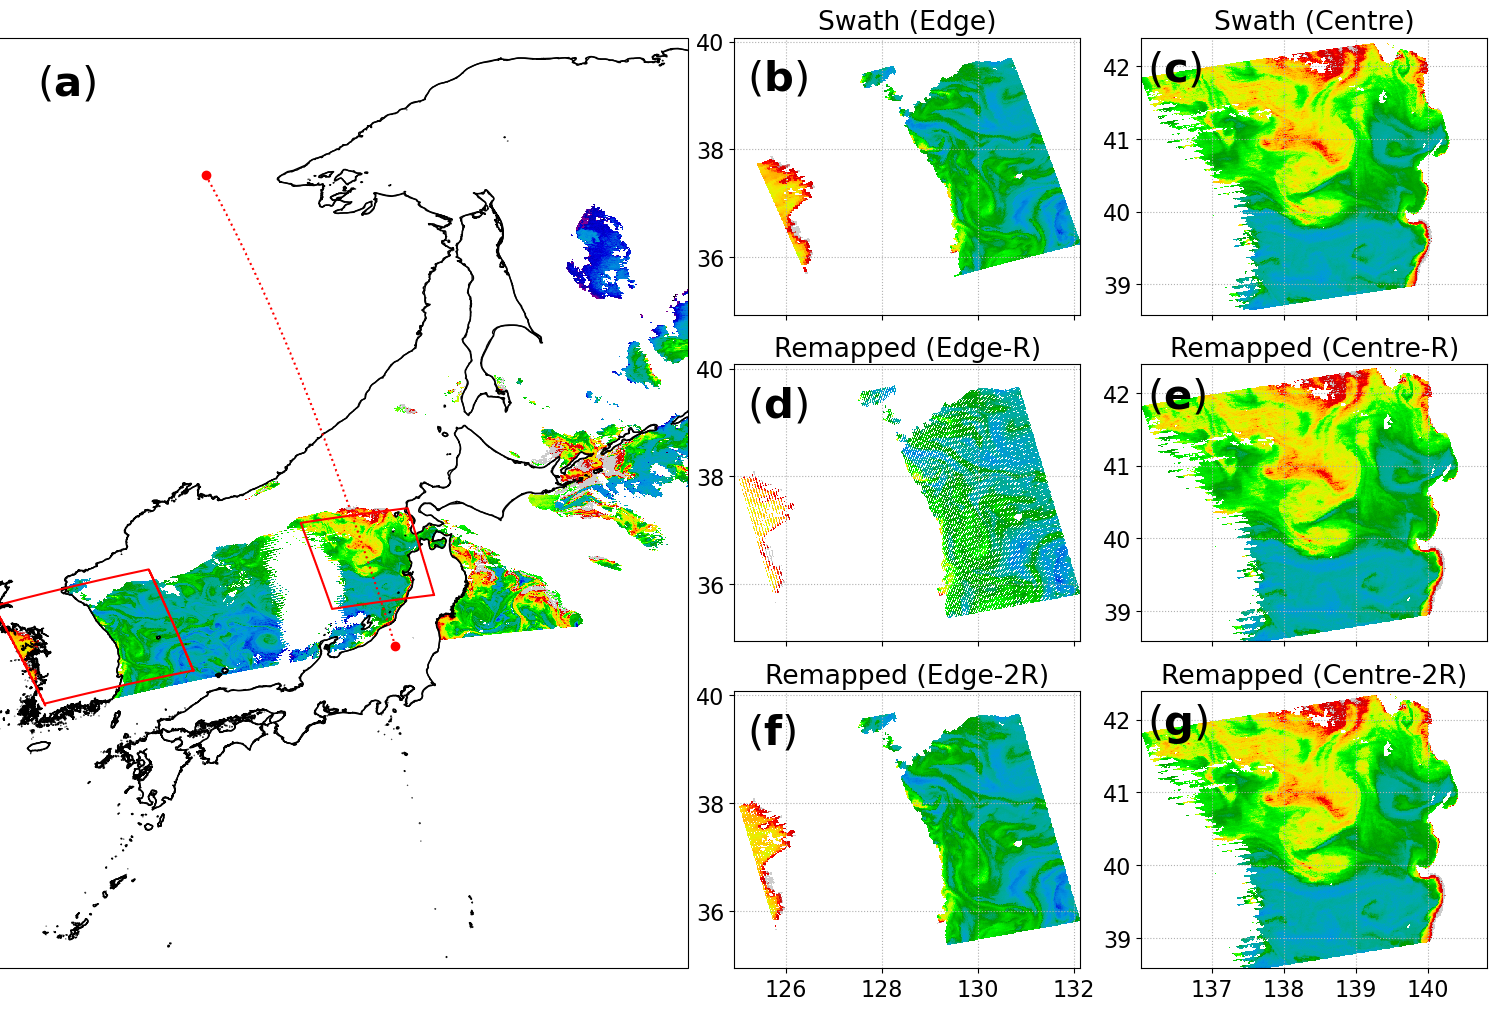

In [10]:
%%time
utils.update_rc_params(figsize=(15, 10), constrained_layout=True)
# map extent 
extent = 125, 150, 25, 60

# near center vs near edge
fig = plt.figure()
gs = gridspec.GridSpec(3, 4, figure=fig)

axm = fig.add_subplot(gs[:, :2], projection=ccrs.PlateCarree())
axm.text(126.5, 58, r'($\rm{\bf{a}}$)', fontsize=30)

ax0 = fig.add_subplot(gs[0, -2])
ax1 = fig.add_subplot(gs[1, -2])
ax2 = fig.add_subplot(gs[2, -2])
ax0.text(125.2, 39.1, r'($\rm{\bf{b}}$)', fontsize=30)
ax1.text(125.2, 39.1, r'($\rm{\bf{d}}$)', fontsize=30)
ax2.text(125.2, 39.1, r'($\rm{\bf{f}}$)', fontsize=30)

ax3 = fig.add_subplot(gs[0, -1])
ax4 = fig.add_subplot(gs[1, -1])
ax5 = fig.add_subplot(gs[2, -1])
ax3.text(136.1, 41.8, r'($\rm{\bf{c}}$)', fontsize=30)
ax4.text(136.1, 41.8, r'($\rm{\bf{e}}$)', fontsize=30)
ax5.text(136.1, 41.8, r'($\rm{\bf{g}}$)', fontsize=30)

axs = (ax3, ax4, ax5), (ax0, ax1, ax2)
bounds = (137, 39, 140, 42), (126, 36, 131, 39)

axm.coastlines()
axm.add_feature(cfeature.GSHHSFeature(scale='h'))
axm.set_extent(extent)
norm = LogNorm(vmin=0.1, vmax=10)
# since swath has no monotonically increasing or decreasing loc data, pass edges

axm.pcolormesh(result['slon'], result['slat'], result['schlor_a'], 
               cmap='nipy_spectral', shading='auto', norm=norm)

axm.plot(result['clon'], result['clat'], ':r')
axm.plot(attrs['start_center_longitude'], 
         attrs['start_center_latitude'], marker='o', color='r')
axm.plot(attrs['end_center_longitude'], 
         attrs['end_center_latitude'], marker='o', color='r')

for bbox, ax, label in zip(bounds, axs, ('Centre', 'Edge')):
    # ---------------------
    # Data within this bbox
    # ---------------------
    sx, sy = subset(xq=result['slon'], yq=result['slat'], bbox=bbox)
    ncx = result['slon'][sy, sx]
    ncy = result['slat'][sy, sx]
    sample0 = result['schlor_a'][sy, sx]
    flags0 = result['sl2_flags'][sy, sx]
    
    # -------------
    # swath polygon
    # -------------
    name = OPATH.joinpath(f'modisa_{label.lower()}2gee.shp')
    px, py = utils.ascending_polygon(xv=ncx, yv=ncy, name=name)
    # Save polygon 
    utils.save_shape(px, py, file=OPATH.joinpath(f'modisa_{label.lower()}.shp'))
    
    axm.plot(px, py, '-r')
    ax[0].pcolormesh(ncx, ncy, sample0, norm=norm, shading='auto', cmap='nipy_spectral')
    ax[0].set_title(f'Swath ({label})')

    bbx = np.min(px)-.5, np.min(py)-.5, np.max(px)+.5, np.max(py)+.5
    sx, sy = subset(xq=result['mlon'], 
                    yq=result['mlat'], bbox=bbx)
    mpx = result['mlon'][sy, sx]
    mpy = result['mlat'][sy, sx]
    extent = mpx.min(), mpx.max(), mpy.min(), mpy.max()

    # ----------------------------------------------
    # resampled within the swath polygon (R and 2*R)
    # ----------------------------------------------
    sample1 = result['mchlor_a'][sy, sx] # 2*R (default)
    sample2 = result['mchlor_a_r'][sy, sx] # R
    flags1 = result['ml2_flags'][sy, sx]

    inpoly = utils.inpolygon(xq=mpx, yq=mpy, xv=px, yv=py)
    sample1 = np.ma.masked_where(~inpoly, sample1)
    sample2 = np.ma.masked_where(~inpoly, sample2)

    ax[1].imshow(sample2, norm=norm, cmap='nipy_spectral', extent=extent, interpolation='nearest')
    ax[1].set_title(f'Remapped ({label}-R)')
    ax[2].imshow(sample1, norm=norm, cmap='nipy_spectral', extent=extent, interpolation='nearest')
    ax[2].set_title(f'Remapped ({label}-2R)')

    for k, axi in enumerate(ax):
        axi.set_xlim([np.min(px), np.max(px)])
        axi.set_ylim([np.min(py), np.max(py)])
        axi.grid(True, axis='both')
        if bbox[0] == 126:
            # axi.set_xticks((131, 132, 133, 134, 135))
            axi.set_yticks((36, 38, 40))
        if bbox[0] == 137:
            axi.set_xticks((137, 138, 139, 140))
            axi.set_yticks((39, 40, 41, 42))
        if k != 2:
            axi.set_xticklabels([])
    
fname = INPUT_FILE.name.replace(INPUT_FILE.suffix, '_swath_mapped.png')
fig.savefig(OPATH.joinpath(fname), dpi=300)

# Probability distribution 

## Compare swath vs. remapped

[Return to the "Table of contents"](#Contents)

Remapped has more pixels than swath due to decrease in spatial resolution towards swath edge

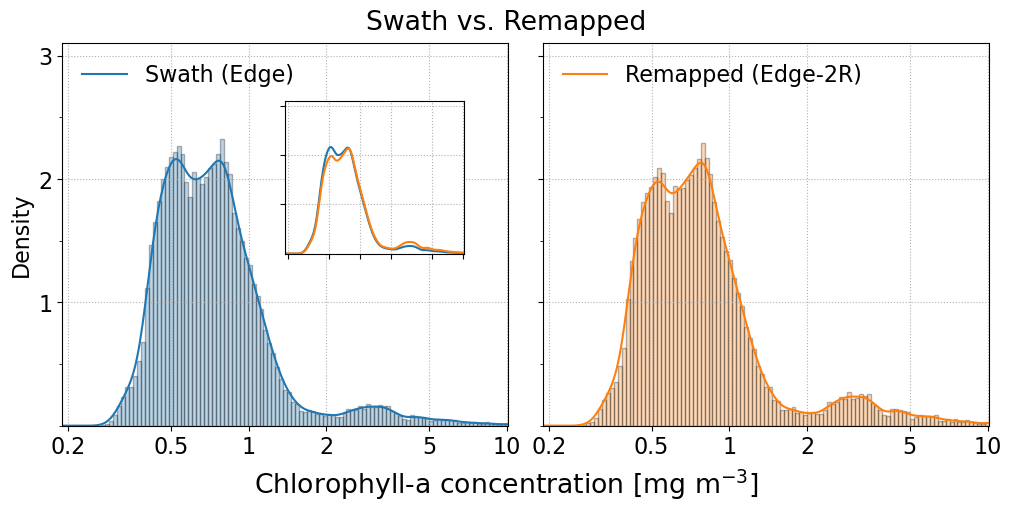

In [11]:
utils.update_rc_params(constrained_layout=True, figsize=(10, 5))
fig, axs = plt.subplots(1, 2, sharey='all')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

density = True
# -----------
# mapped data
# -----------
hist1 = np.ma.log10(sample1)
hist1 = np.ma.compressed(hist1)
dist = pd.DataFrame([], index=range(hist1.size),
                    columns=['Swath (Edge)', 'Remapped (Edge-2R)'])
dist['Remapped (Edge-2R)'] = hist1

# -----
# swath
# -----
hist_size = sample0.shape[1]
hist0 = np.ma.compressed(np.ma.log10(sample0.flatten()))
# mapped has more pixels
loc = np.bool_(np.zeros((hist1.size,)))
loc[:hist0.size] = True
dist.loc[loc, 'Swath (Edge)'] = hist0

zipped = zip(axs, ('Swath (Edge)', 'Remapped (Edge-2R)'), (hist0, hist1))
for k, (ax, lab, data) in enumerate(zipped):
    ax.hist(data, hist_size, density=density, 
            ec='k', fc=colors[k], alpha=0.3)
    dist[lab].plot.kde(ax=ax, legend=False, color=colors[k])
    ax.set_xticks(np.log10((0.2, 0.5, 1, 2, 5, 10)))
    ax.set_xticklabels((0.2, 0.5, 1, 2, 5, 10))
    ax.set_xlim(np.log10((0.19, 10.1)))
    ax.set_yticks((1, 2, 3))
    ax.set_ylim(0, 3.1)
    ax.legend(frameon=False, loc='upper left')

axins = axs[0].inset_axes([0.5, 0.45, 0.4, 0.4])
dist.plot.kde(ax=axins)
axins.set_xlim(np.log10((0.19, 10.1)))
axins.set_xticks(np.log10((0.2, 0.5, 1, 2, 5, 10)))
axins.set_ylim(ax.get_ylim())
axins.set_yticks((1, 2, 3))
axins.set_ylabel("")
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.get_legend().remove()

fig.suptitle('Swath vs. Remapped')
fig.supxlabel('Chlorophyll-a concentration [mg m$^{-3}$]')
axs[0].set_ylabel('Density')

fname = INPUT_FILE.name.replace(INPUT_FILE.suffix, f'_chl_prob.png')
fig.savefig(OPATH.joinpath(fname), dpi=300)

- Statistics of the swath vs. remapped data.

In [12]:
hist2 = np.ma.compressed(np.ma.log10(sample2.flatten()))
# mapped has more pixels
loc = np.bool_(np.zeros((hist1.size,)))
loc[:hist2.size] = True
dist.loc[loc, 'Remapped (R)'] = hist2

desc = dist.astype(float).describe()
index = desc.index
desc.loc[index[1:], :] = 10**desc.loc[index[1:], :]
desc

,Swath (Edge),Remapped (Edge-2R),Remapped (R)
count,36591.000,92072.000,72827.000
mean,0.740,0.795,0.741
std,1.703,1.836,1.698
min,0.269,0.269,0.269
25%,0.518,0.531,0.521
50%,0.685,0.716,0.689
75%,0.906,0.959,0.906
max,93.196,93.196,93.196


In [13]:
s = desc.loc['count', 'Swath (Edge)']
m = desc.loc['count', 'Remapped (Edge-2R)']

print(f"{(100 * (m - s) / s):.0f}%")

152%


# Quality flag info 

## Compare swath vs. remapped

[Return to the "Table of contents"](#Contents)

Remapped has more pixels than swath due to decrease in spatial resolution towards swath edge

In [14]:
def get_flags(array, size):
    ar = np.asarray(
        array).flatten().astype(array.dtype)
    n = ar.size
    r = np.empty((size, n), dtype=int)
    for bit in range(size):
        shift = (1 << bit) & ar
        r[bit, :] = (shift > 0).astype(int)
    return r

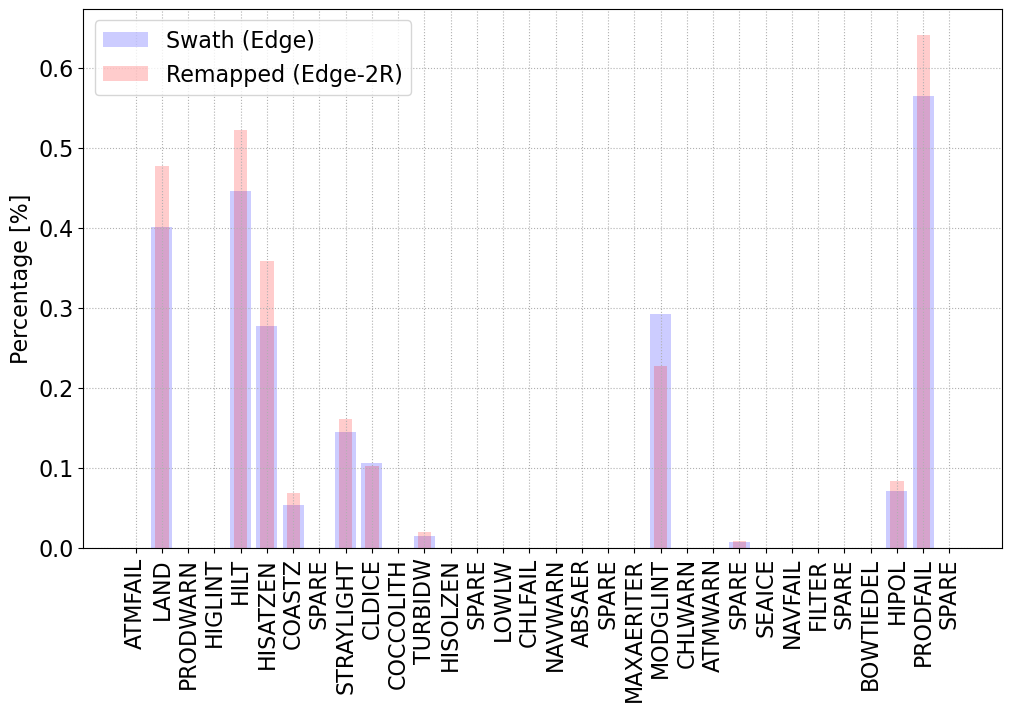

In [15]:
utils.update_rc_params(constrained_layout=True, 
                       figsize=(10, 7))
fig, ax = plt.subplots()

# --------
# l2_flags
# --------

# flags in each pixel
bits0 = get_flags(array=flags0, size=32)
# count
found0 = bits0.sum(axis=1) / flags0.size
bins = np.arange(0, 32)
ax.bar(bins, height=found0, label='Swath (Edge)', fc='b',
       align='center', width=0.8, bottom=0, alpha=0.2)

bits1 = get_flags(array=flags1[inpoly], size=32)
found1 = bits1.sum(axis=1) / flags1[inpoly].size
ax.bar(bins, height=found1, label='Remapped (Edge-2R)', fc='r',
       align='center', width=0.5, bottom=0, alpha=0.2)

ax.legend()
ax.set_xticks(bins)

ax.set_xticklabels(flag_names)
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Percentage [%]')

fname = INPUT_FILE.name.replace(INPUT_FILE.suffix, '_flags_dist.png')
fig.savefig(OPATH.joinpath(fname), dpi=300)

In [16]:
s = bits0.sum(axis=1)[5]
m = bits1.sum(axis=1)[5]

print(f"{(100 * (m - s) / s):.0f}%")

292%
